This code is modified from tensorflow tutorial: https://www.tensorflow.org/tutorials/images/transfer_learning

# Import Libraries

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import mlflow

# MLflow Autologging

In [0]:
mlflow.tensorflow.autolog()

# Create Train, Validation, and Test Sets

In [0]:
# Set random seed
tf.keras.utils.set_random_seed(42)

In [0]:
# Define paths
_URL = 'https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip'
path_to_zip = tf.keras.utils.get_file('cats_and_dogs.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'cats_and_dogs_filtered')
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'validation')

# Load train and validation sets
BATCH_SIZE = 32
IMG_SIZE = (160, 160)

In [0]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE
                                                            )

Found 2000 files belonging to 2 classes.

In [0]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE
                                                                 )

Found 1000 files belonging to 2 classes.

In [0]:
# Set a portion of the validation set aside for the test set
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 5)
validation_dataset = validation_dataset.skip(val_batches // 5)
# Print dataset sizes
print(f"Train Dataset: {len(train_dataset)} batches")
print(f"Validation Dataset: {len(validation_dataset)} batches")
print(f"Test Dataset: {len(test_dataset)} batches")

Train Dataset: 63 batches
Validation Dataset: 26 batches
Test Dataset: 6 batches

# Display Example Images

In [0]:
# Extract class names
class_names = train_dataset.class_names

# Display 9 example images with their class names
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[labels[i]])
        plt.axis("off")

# Optimize Image Loading

In [0]:
# Use buffered prefetching to load images from disk - https://www.tensorflow.org/guide/data_performance
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

# Augment Data

In [0]:
# Increase generalizability of model adding flipped and rotates images to the dataset
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [0]:
# Display example of augmented images from an image in dataset
for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

# Load Base Imagenet Model: MobileNetV2

In [0]:
# Load base imagenet model MobileNetV2. include_top=False so we drop the final layer
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')
# Freeze base weights so they don't retrain
base_model.trainable = False

# Display the base model architecture
base_model.summary()

Model: "mobilenetv2_1.00_160"
__________________________________________________________________________________________________
 Layer (type) Output Shape Param # Connected to 
==================================================================================================
 input_1 (InputLayer) [(None, 160, 160, 3 0 [] 
 )] 
 
 Conv1 (Conv2D) (None, 80, 80, 32) 864 ['input_1[0][0]'] 
 
 bn_Conv1 (BatchNormalization) (None, 80, 80, 32) 128 ['Conv1[0][0]'] 
 
 Conv1_relu (ReLU) (None, 80, 80, 32) 0 ['bn_Conv1[0][0]'] 
 
 expanded_conv_depthwise (Depth (None, 80, 80, 32) 288 ['Conv1_relu[0][0]'] 
 wiseConv2D) 
 
 expanded_conv_depthwise_BN (Ba (None, 80, 80, 32) 128 ['expanded_conv_depthwise[0][0]']
 tchNormalization) 
 
 expanded_conv_depthwise_relu ( (None, 80, 80, 32) 0 ['expanded_conv_depthwise_BN[0][0
 ReLU) ]'] 
 
 expanded_conv_project (Conv2D) (None, 80, 80, 16) 512 ['expanded_conv_depthwise_relu[0]
 [0]'] 
 
 expanded_conv_project_BN (Batc (None, 80, 80, 16) 64 ['expanded_conv_project[0][0]'] 
 hNormalization) 
 
 block_1_expand (Conv2D) (None, 80, 80, 96) 1536 ['expanded_conv_project_BN[0][0]'
 ] 
 
 block_1_expand_BN (BatchNormal (None, 80, 80, 96) 384 ['block_1_expand[0][0]'] 
 ization) 
 
 block_1_expand_relu (ReLU) (None, 80, 80, 96) 0 ['block_1_expand_BN[0][0]'] 
 
 block_1_pad (ZeroPadding2D) (None, 81, 81, 96) 0 ['block_1_expand_relu[0][0]'] 
 
 block_1_depthwise (DepthwiseCo (None, 40, 40, 96) 864 ['block_1_pad[0][0]'] 
 nv2D) 
 
 block_1_depthwise_BN (BatchNor (None, 40, 40, 96) 384 ['block_1_depthwise[0][0]'] 
 malization) 
 
 block_1_depthwise_relu (ReLU) (None, 40, 40, 96) 0 ['block_1_depthwise_BN[0][0]'] 
 
 block_1_project (Conv2D) (None, 40, 40, 24) 2304 ['block_1_depthwise_relu[0][0]'] 
 
 block_1_project_BN (BatchNorma (None, 40, 40, 24) 96 ['block_1_project[0][0]'] 
 lization) 
 
 block_2_expand (Conv2D) (None, 40, 40, 144) 3456 ['block_1_project_BN[0][0]'] 
 
 block_2_expand_BN (BatchNormal (None, 40, 40, 144) 576 ['block_2_expand[0][0]'] 
 ization) 
 
 block_2_expand_relu (ReLU) (None, 40, 40, 144) 0 ['block_2_expand_BN[0][0]'] 
 
 block_2_depthwise (DepthwiseCo (None, 40, 40, 144) 1296 ['block_2_expand_relu[0][0]'] 
 nv2D) 
 
 block_2_depthwise_BN (BatchNor (None, 40, 40, 144) 576 ['block_2_depthwise[0][0]'] 
 malization) 
 
 block_2_depthwise_relu (ReLU) (None, 40, 40, 144) 0 ['block_2_depthwise_BN[0][0]'] 
 
 block_2_project (Conv2D) (None, 40, 40, 24) 3456 ['block_2_depthwise_relu[0][0]'] 
 
 block_2_project_BN (BatchNorma (None, 40, 40, 24) 96 ['block_2_project[0][0]'] 
 lization) 
 
 block_2_add (Add) (None, 40, 40, 24) 0 ['block_1_project_BN[0][0]', 
 'block_2_project_BN[0][0]'] 
 
 block_3_expand (Conv2D) (None, 40, 40, 144) 3456 ['block_2_add[0][0]'] 
 
 block_3_expand_BN (BatchNormal (None, 40, 40, 144) 576 ['block_3_expand[0][0]'] 
 ization) 
 
 block_3_expand_relu (ReLU) (None, 40, 40, 144) 0 ['block_3_expand_BN[0][0]'] 
 
 block_3_pad (ZeroPadding2D) (None, 41, 41, 144) 0 ['block_3_expand_relu[0][0]'] 
 
 block_3_depthwise (DepthwiseCo (None, 20, 20, 144) 1296 ['block_3_pad[0][0]'] 
 nv2D) 
 
 block_3_depthwise_BN (BatchNor (None, 20, 20, 144) 576 ['block_3_depthwise[0][0]'] 
 malization) 
 
 block_3_depthwise_relu (ReLU) (None, 20, 20, 144) 0 ['block_3_depthwise_BN[0][0]'] 
 
 block_3_project (Conv2D) (None, 20, 20, 32) 4608 ['block_3_depthwise_relu[0][0]'] 
 
 block_3_project_BN (BatchNorma (None, 20, 20, 32) 128 ['block_3_project[0][0]'] 
 lization) 
 
 block_4_expand (Conv2D) (None, 20, 20, 192) 6144 ['block_3_project_BN[0][0]'] 
 
 block_4_expand_BN (BatchNormal (None, 20, 20, 192) 768 ['block_4_expand[0][0]'] 
 ization) 
 
 block_4_expand_relu (ReLU) (None, 20, 20, 192) 0 ['block_4_expand_BN[0][0]'] 
 
 block_4_depthwise (DepthwiseCo (None, 20, 20, 192) 1728 ['block_4_expand_relu[0][0]'] 
 nv2D) 
 
 block_4_depthwise_BN (BatchNor (None, 20, 20, 192) 768 ['block_4_depthwise[0][0]'] 
 malization) 
 
 block_4_depthwise_relu (ReLU) (None, 20, 20, 192) 0 ['block_4_depthwise_BN[0][0]'

# Define Model

In [0]:
# Define preprocessing layers
preprocess_input = tf.keras.applications.mobilenet_v2.preprocess_input
rescale = tf.keras.layers.Rescaling(1./127.5, offset=-1) # Alternatively

# Define new prediction layers for cats vs. dogs classification
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
prediction_layer = tf.keras.layers.Dense(1)

# Define model layers
inputs = tf.keras.Input(shape=(160, 160, 3)) # image input shape
x = data_augmentation(inputs) # apply image preprocessing layers
x = preprocess_input(x)
x = base_model(x, training=False) # apply base model, without retraining its weights
x = global_average_layer(x) # apply final prediction layers
x = tf.keras.layers.Dropout(0.2)(x)
outputs = prediction_layer(x) 

# Create model from model layers
model = tf.keras.Model(inputs, outputs)

# Compile model 
learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Display model summary
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type) Output Shape Param # 
=================================================================
 input_2 (InputLayer) [(None, 160, 160, 3)] 0 
 
 sequential (Sequential) (None, 160, 160, 3) 0 
 
 tf.math.truediv (TFOpLambda (None, 160, 160, 3) 0 
 ) 
 
 tf.math.subtract (TFOpLambd (None, 160, 160, 3) 0 
 a) 
 
 mobilenetv2_1.00_160 (Funct (None, 5, 5, 1280) 2257984 
 ional) 
 
 global_average_pooling2d (G (None, 1280) 0 
 lobalAveragePooling2D) 
 
 dropout (Dropout) (None, 1280) 0 
 
 dense (Dense) (None, 1) 1281 
 
=================================================================
Total params: 2,259,265
Trainable params: 1,281
Non-trainable params: 2,257,984
_________________________________________________________________

# Train Model

In [0]:
# Train model for num_epochs
num_epochs = 5
history = model.fit(train_dataset,
                    epochs=num_epochs,
                    validation_data=validation_dataset)

2022/07/23 19:10:46 INFO mlflow.utils.autologging_utils: Created MLflow autologging run with ID '6466d00f4b344c5b9f2e980f0c9c70e7', which will track hyperparameters, performance metrics, model artifacts, and lineage information for the current tensorflow workflow
Epoch 1/5
 1/63 [..............................] - ETA: 2:37 - loss: 1.0528 - accuracy: 0.4688 2/63 [..............................] - ETA: 6s - loss: 0.9051 - accuracy: 0.4688  3/63 [>.............................] - ETA: 6s - loss: 0.9071 - accuracy: 0.4688 4/63 [>.............................] - ETA: 5s - loss: 0.8684 - accuracy: 0.4766 5/63 [=>............................] - ETA: 5s - loss: 0.8492 - accuracy: 0.5000 6/63 [=>............................] - ETA: 5s - loss: 0.8852 - accuracy: 0.4792 7/63 [==>...........................] - ETA: 5s - loss: 0.8657 - accuracy: 0.4911 8/63 [==>...........................] - ETA: 4s - loss: 0.8590 - accuracy: 0.4844 9/63 [===>..........................] - ETA: 4s - loss: 0.8529 - accuracy: 0.493110/63 [===>..........................] - ETA: 4s - loss: 0.8515 - accuracy: 0.503111/63 [====>.........................] - ETA: 4s - loss: 0.8608 - accuracy: 0.497212/63 [====>.........................] - ETA: 4s - loss: 0.8501 - accuracy: 0.502613/63 [=====>........................] - ETA: 4s - loss: 0.8647 - accuracy: 0.492814/63 [=====>........................] - ETA: 4s - loss: 0.8680 - accuracy: 0.491115/63 [======>.......................] - ETA: 4s - loss: 0.8646 - accuracy: 0.489616/63 [======>.......................] - ETA: 4s - loss: 0.8546 - accuracy: 0.498017/63 [=======>......................] - ETA: 4s - loss: 0.8528 - accuracy: 0.496318/63 [=======>......................] - ETA: 3s - loss: 0.8424 - accuracy: 0.498319/63 [========>.....................] - ETA: 3s - loss: 0.8409 - accuracy: 0.495120/63 [========>.....................] - ETA: 3s - loss: 0.8354 - accuracy: 0.500021/63 [=========>....................] - ETA: 3s - loss: 0.8338 - accuracy: 0.500022/63 [=========>....................] - ETA: 3s - loss: 0.8340 - accuracy: 0.492923/63 [=========>....................] - ETA: 3s - loss: 0.8362 - accuracy: 0.5014

# Display Loss and Accuracy Graph

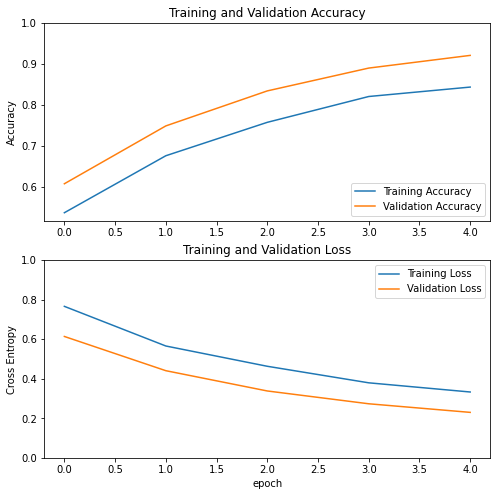

In [0]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

# Display Test Set Predictions

In [0]:
# Test set performance
loss, accuracy = model.evaluate(test_dataset)
print(f"Test set loss: {loss}, Test set accuracy: {accuracy}")

1/6 [====>.........................] - ETA: 0s - loss: 0.2580 - accuracy: 0.87502/6 [=========>....................] - ETA: 0s - loss: 0.2340 - accuracy: 0.89063/6 [==============>...............] - ETA: 0s - loss: 0.2497 - accuracy: 0.89584/6 [===================>..........] - ETA: 0s - loss: 0.2572 - accuracy: 0.89065/6 [========================>.....] - ETA: 0s - loss: 0.2566 - accuracy: 0.90006/6 [==============================] - ETA: 0s - loss: 0.2408 - accuracy: 0.91156/6 [==============================] - 1s 86ms/step - loss: 0.2408 - accuracy: 0.9115
Test set loss: 0.24082688987255096, Test set accuracy: 0.9114583134651184

Predictions:
 [1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 0 0 1 1 0 1 1 0 1 1 0 0 0 0 0 1]
Labels:
 [1 1 1 1 0 1 0 0 1 0 0 1 0 0 1 1 1 0 1 1 0 1 1 0 1 1 0 0 0 0 0 0]

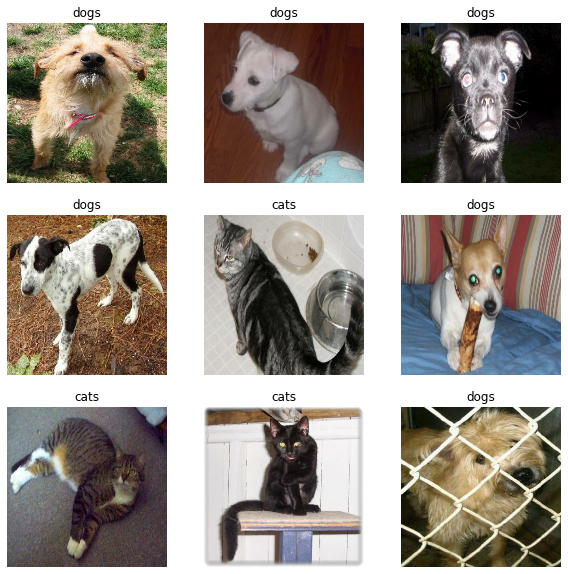

In [0]:
# Retrieve a batch of images from the test set
image_batch, label_batch = test_dataset.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch).flatten()

# Apply a sigmoid since our model returns logits
predictions = tf.nn.sigmoid(predictions)
predictions = tf.where(predictions < 0.5, 0, 1)

print('Predictions:\n', predictions.numpy())
print('Labels:\n', label_batch)

plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(image_batch[i].astype("uint8"))
    plt.title(class_names[predictions[i]])
    plt.axis("off")